In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vegemite.csv


# Step 1: Data Preparation

#  Shuffle the dataset

In [2]:
dataset = pd.read_csv('/kaggle/input/vegemite.csv')

In [3]:
shuffled_df = dataset.sample(n=len(dataset))

# Reset the index
shuffled_df = shuffled_df.reset_index(drop=True)

# Randomly take out 1000 data points (rows) such as way that each class in those 1000 samples has near equal distribution (e.g. at least 300 samples from each class)

In [4]:
# Sample 1000 data points, ensuring equal class distribution
class0 = shuffled_df[shuffled_df['Class'] == 0].sample(n=333, random_state= 1)
class1 = shuffled_df[shuffled_df['Class'] == 1].sample(n=334, random_state = 1)
class2 = shuffled_df[shuffled_df['Class'] == 2].sample(n=333, random_state = 1)

sample_df = pd.concat([class0, class1, class2])  

remaining_data_points = shuffled_df.drop(sample_df.index)

In [5]:
shuffled_df.head()

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,TFE Steam temperature SP,FFTE Feed flow SP,FFTE Out steam temp SP,...,TFE Out flow PV,TFE Product out temperature,TFE Production solids PV,TFE Production solids density,TFE Steam pressure PV,TFE Steam temperature,TFE Tank level,TFE Temperature,TFE Vacuum pressure PV,Class
0,50.0,43.00,130.0,2609.30,65.0,-80.00,120.0,80.0,10000.0,50.40,...,1616.08,0.0,39.61,1.20,119.91,68.15,50.71,74.0,-72.11,1
1,25.0,43.00,130.0,2255.81,51.0,-40.74,120.0,80.0,9500.0,50.00,...,2116.08,0.0,69.27,1.25,120.23,71.27,82.42,71.0,-78.46,2
2,50.0,40.50,104.0,2296.30,63.0,-79.78,125.0,80.0,9300.0,40.71,...,2083.66,0.0,60.35,1.22,0.06,44.60,83.05,68.0,-57.27,1
3,50.0,41.11,125.0,2506.91,60.0,-75.90,125.0,80.0,9220.0,50.00,...,2449.42,0.0,77.88,1.03,119.91,83.44,80.43,85.0,-55.52,2
4,50.0,43.00,128.0,2846.51,69.0,-78.63,120.0,80.0,10200.0,50.00,...,1795.72,0.0,49.68,1.35,119.58,65.88,77.34,75.0,-76.00,2


In [6]:
sample_df.to_csv('1000_data_points.csv')

# Remove constant value columns

In [7]:
from sklearn.model_selection import train_test_split

X = remaining_data_points.iloc[:, :-1]
y = remaining_data_points.iloc[:, -1]

In [8]:
constant_features = remaining_data_points.columns[remaining_data_points.nunique() == 1]
print(constant_features)

Index(['TFE Steam temperature SP', 'TFE Product out temperature'], dtype='object')


In [9]:
# Remove constant value columns
remaining_data_points = remaining_data_points.loc[:, remaining_data_points.nunique() > 1]

# Convert columns with few integer values to categorial feature.

In [10]:
few_int_values_columns = []
for col in X.columns:
    if X[col].nunique() < 10:
        few_int_values_columns.append(col)
print(few_int_values_columns)

['FFTE Feed tank level SP', 'TFE Steam temperature SP', 'FFTE Pump 1', 'FFTE Pump 1 - 2', 'FFTE Pump 2', 'TFE Motor speed', 'TFE Product out temperature']


In [11]:
X[few_int_values_columns] = X[few_int_values_columns].astype('category')
print(X.dtypes)

FFTE Feed tank level SP          category
FFTE Production solids SP         float64
FFTE Steam pressure SP            float64
TFE Out flow SP                   float64
TFE Production solids SP          float64
TFE Vacuum pressure SP            float64
TFE Steam pressure SP             float64
TFE Steam temperature SP         category
FFTE Feed flow SP                 float64
FFTE Out steam temp SP            float64
Extract tank Level                float64
Extract tank Out flow PV          float64
FFTE Discharge density            float64
FFTE Discharge solids             float64
FFTE Feed flow rate PV            float64
FFTE Feed tank level PV           float64
FFTE Heat temperature 1           float64
FFTE Heat temperature 2           float64
FFTE Heat temperature 3           float64
FFTE Out steam temp PV            float64
FFTE Production solids PV         float64
FFTE Pump 1                      category
FFTE Pump 1 - 2                  category
FFTE Pump 2                      c

# Does the class have a balanced distribution? If not then perform necessary undersampling and oversampling or adjust class weights

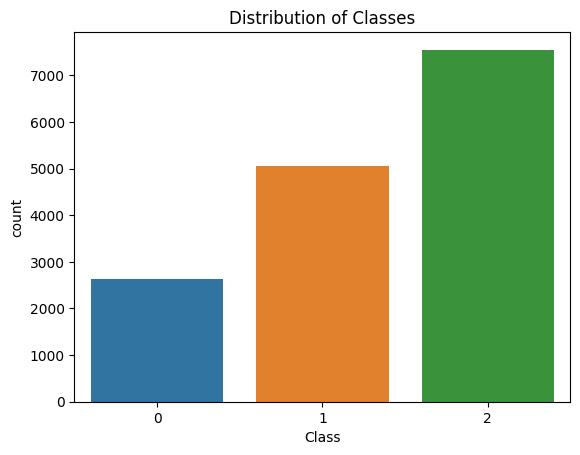

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data = dataset)
plt.title('Distribution of Classes')
plt.show()

In [13]:
class_count = y.value_counts()
print(class_count)

Class
2    7215
1    4713
0    2309
Name: count, dtype: int64


In [14]:
# Class balancing distribution using oversampling (SMOTE)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

smote = SMOTETomek(smote=SMOTE(random_state=1), tomek=TomekLinks(sampling_strategy='majority'))

# Fit the resampled data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=1)

In [15]:
remaining_data_points.head()

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,FFTE Feed flow SP,FFTE Out steam temp SP,Extract tank Level,...,TFE Motor speed,TFE Out flow PV,TFE Production solids PV,TFE Production solids density,TFE Steam pressure PV,TFE Steam temperature,TFE Tank level,TFE Temperature,TFE Vacuum pressure PV,Class
0,50.0,43.00,130.0,2609.30,65.0,-80.00,120.0,10000.0,50.40,49.29,...,80.0,1616.08,39.61,1.20,119.91,68.15,50.71,74.0,-72.11,1
1,25.0,43.00,130.0,2255.81,51.0,-40.74,120.0,9500.0,50.00,51.80,...,80.0,2116.08,69.27,1.25,120.23,71.27,82.42,71.0,-78.46,2
2,50.0,40.50,104.0,2296.30,63.0,-79.78,125.0,9300.0,40.71,15.11,...,80.0,2083.66,60.35,1.22,0.06,44.60,83.05,68.0,-57.27,1
3,50.0,41.11,125.0,2506.91,60.0,-75.90,125.0,9220.0,50.00,48.63,...,80.0,2449.42,77.88,1.03,119.91,83.44,80.43,85.0,-55.52,2
4,50.0,43.00,128.0,2846.51,69.0,-78.63,120.0,10200.0,50.00,53.05,...,80.0,1795.72,49.68,1.35,119.58,65.88,77.34,75.0,-76.00,2


# Composite features

In [16]:
# 1. Energy Efficiency Ratio
remaining_data_points['Energy_Efficiency'] = remaining_data_points['TFE Production solids PV'] / remaining_data_points['TFE Steam pressure PV']

# 2. Flow Rate Balance
remaining_data_points['Flow_Balance'] = remaining_data_points['TFE Out flow PV'] - remaining_data_points['FFTE Feed flow rate PV']

# 3. Temperature Gradient
remaining_data_points['Temp_Gradient'] = remaining_data_points['TFE Steam temperature'] - remaining_data_points['FFTE Out steam temp PV']

# 4. Vacuum Efficiency Index
remaining_data_points['Vacuum_Efficiency'] = remaining_data_points['TFE Vacuum pressure PV'] / remaining_data_points['TFE Out flow PV']

In [17]:
remaining_data_points.head()

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,FFTE Feed flow SP,FFTE Out steam temp SP,Extract tank Level,...,TFE Steam pressure PV,TFE Steam temperature,TFE Tank level,TFE Temperature,TFE Vacuum pressure PV,Class,Energy_Efficiency,Flow_Balance,Temp_Gradient,Vacuum_Efficiency
0,50.0,43.00,130.0,2609.30,65.0,-80.00,120.0,10000.0,50.40,49.29,...,119.91,68.15,50.71,74.0,-72.11,1,0.330331,-8388.46,18.00,-0.044620
1,25.0,43.00,130.0,2255.81,51.0,-40.74,120.0,9500.0,50.00,51.80,...,120.23,71.27,82.42,71.0,-78.46,2,0.576146,-8535.67,21.18,-0.037078
2,50.0,40.50,104.0,2296.30,63.0,-79.78,125.0,9300.0,40.71,15.11,...,0.06,44.60,83.05,68.0,-57.27,1,1005.833333,-7285.99,-5.49,-0.027485
3,50.0,41.11,125.0,2506.91,60.0,-75.90,125.0,9220.0,50.00,48.63,...,119.91,83.44,80.43,85.0,-55.52,2,0.649487,-7766.53,33.45,-0.022667
4,50.0,43.00,128.0,2846.51,69.0,-78.63,120.0,10200.0,50.00,53.05,...,119.58,65.88,77.34,75.0,-76.00,2,0.415454,-8516.21,16.30,-0.042323


In [18]:
remaining_data_points.to_csv('remaining.csv')

# Step 2: Feature selection, Model Training and Train

# Does the training process need all features? If not, can you apply some feature selection technique to remove some features? Justify your reason of feature selection

In [19]:
# Finally, how many features you have in your final dataset?
features = X_resampled.shape[1]  # After oversampling
print(f'The features in the dataset are: {features} features.')

The features in the dataset are: 46 features.


# Train multiple ML models (at least 5 including DecisionTreeClassifier) with your selected features.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.impute import SimpleImputer

In [21]:
# Handle missing values manually
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_resampled)
X_test_imputed = imputer.transform(X_test)

# Models to train 
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

# Evaluate each model with classification report and confusion matrix

In [22]:
# Train and evaluate the models
results = {}
for model_name, model in models.items():
    model.fit(X_train_imputed, y_train_resampled)
    predictions = model.predict(X_test_imputed)
    
    # Get the classification report and confusion matrix
    report = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    # Store the results
    results[model_name] = {
        'report': report,
        'confusion_matrix': cm
    }

# Print the results in the desired format
for model_name, result in results.items():
    print(f"Classification test_report for {model_name}:")
    print(result['report'])
    print(f"Confusion Matrix for {model_name}:")
    print(result['confusion_matrix'])
    print("\n" + "="*50 + "\n")

Classification test_report for DecisionTree:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1436
           1       0.97      0.96      0.96      1443
           2       0.97      0.98      0.98      1443

    accuracy                           0.97      4322
   macro avg       0.97      0.97      0.97      4322
weighted avg       0.97      0.97      0.97      4322

Confusion Matrix for DecisionTree:
[[1400   28    8]
 [  24 1384   35]
 [   7   19 1417]]


Classification test_report for RandomForest:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1436
           1       0.99      0.99      0.99      1443
           2       0.99      0.99      0.99      1443

    accuracy                           0.99      4322
   macro avg       0.99      0.99      0.99      4322
weighted avg       0.99      0.99      0.99      4322

Confusion Matrix for RandomForest:
[[1433    3    0]
 [ 

# Compare all the models across different evaluation measures and generate a comparison table

In [23]:
# Initialize an empty list to store the results
comparison_data = []

# Train and evaluate the models
for model_name, model in models.items():
    model.fit(X_train_imputed, y_train_resampled)
    predictions = model.predict(X_test_imputed)
    
    # Get classification report
    report = classification_report(y_test, predictions, output_dict=True)
    
    # Extract the necessary metrics from the classification report
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    # Append the data for the current model
    comparison_data.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
comparison_df

,Model,Accuracy,Precision,Recall,F1 Score
0,DecisionTree,0.974317,0.974314,0.974317,0.974291
1,RandomForest,0.993059,0.993057,0.993059,0.993055
2,GradientBoosting,0.928737,0.928705,0.928737,0.928547
3,SVM,0.462980,0.467232,0.462980,0.414422
4,KNN,0.860944,0.862861,0.860944,0.859933


# Now select your best performing model to use that as AI. Justify the reason of your selection

In [24]:
best_model_name = comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Model']
best_model = models[best_model_name]
best_accuracy = comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Accuracy']

print(f"The best performing model is: {best_model}")
print(f"The best accuracy is: {best_accuracy:.10f}")

The best performing model is: RandomForestClassifier()
The best accuracy is: 0.9930587691


# Save selected model

In [25]:
import joblib 
# Save the trained best model to a file (Kaggle uses `joblib` for model saving)
model_filename = "best_model.pkl"
joblib.dump(best_model, model_filename)

['best_model.pkl']

# Step 3: ML to AI

# Take the 1000 rows that you have not used (we put aside at the beginning )

In [26]:
df = pd.read_csv('/kaggle/working/1000_data_points.csv')
# sample_df is saved as '1000_data_points.csv' file in step 1

# Load model

In [27]:
best_model = joblib.load('/kaggle/working/best_model.pkl')

# Iteratively convert columns in each row in the format of your training feature set

In [28]:
X_test = sample_df.drop(columns='Class', axis=1)
y_test = sample_df['Class']

# Find class prediction using the loaded model and compare with the original label

In [29]:
y_pred = best_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


# Measure the performance of your best model for 1000 unseen data points

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [31]:
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix: {confusion_matrix}')
print(f'Classification Report: {classification_report}')

Accuracy: 0.8609440074039797
Confusion Matrix: <function confusion_matrix at 0x7f13aed0cee0>
Classification Report: <function classification_report at 0x7f13aed0d900>


# Now measure the performance of other model using these 1000 data points. Have you observed same result of model selection that you identified through evaluation ?

In [32]:
# Handle missing values manually
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_resampled)
X_test_imputed = imputer.transform(X_test)

# Models to train 
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Iterate over models to train and evaluate
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    # Handle missing values for the training and test set manually
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train_resampled)
    X_test_imputed = imputer.transform(X_test)

    # Train the model
    model.fit(X_train_imputed, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test_imputed)

    # Measure performance
    accuracy = accuracy_score(y_test, y_pred)
    
    # Avoid the name conflict by renaming the confusion matrix variable
    conf_matrix_result = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print performance for the current model
    print(f"\nPerformance of {model_name} on 1000 Unseen Data Points:")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", conf_matrix_result)
    print("Classification Report:\n", class_report)


Evaluating DecisionTree...

Performance of DecisionTree on 1000 Unseen Data Points:
Accuracy: 0.967
Confusion Matrix:
 [[320   8   5]
 [  6 320   8]
 [  0   6 327]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97       333
           1       0.96      0.96      0.96       334
           2       0.96      0.98      0.97       333

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000


Evaluating RandomForest...

Performance of RandomForest on 1000 Unseen Data Points:
Accuracy: 0.991
Confusion Matrix:
 [[330   2   1]
 [  1 329   4]
 [  0   1 332]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       333
           1       0.99      0.99      0.99       334
           2       0.99      1.00      0.99       333

    accuracy         

# Step 4: Develop rules from ML model

In [34]:
from sklearn.tree import export_text 
sp_features = [col for col in remaining_data_points.columns if col.endswith('SP')] 
X_sp = remaining_data_points[sp_features] 
y_sp= remaining_data_points['Class'] 

decisiontree_sp = DecisionTreeClassifier(random_state = 1) 
decisiontree_sp.fit(X_sp, y_sp) 

tree_rules = export_text(decisiontree_sp, feature_names=sp_features) 
print(tree_rules)

|--- TFE Out flow SP <= 2249.11
|   |--- FFTE Steam pressure SP <= 119.98
|   |   |--- TFE Out flow SP <= 2100.70
|   |   |   |--- TFE Vacuum pressure SP <= -67.99
|   |   |   |   |--- FFTE Feed flow SP <= 9395.00
|   |   |   |   |   |--- TFE Production solids SP <= 64.25
|   |   |   |   |   |   |--- FFTE Steam pressure SP <= 103.50
|   |   |   |   |   |   |   |--- FFTE Steam pressure SP <= 94.00
|   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 52.75
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- TFE Production solids SP >  52.75
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 60.00
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP >  60.00
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP <= -76.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP 